In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./Sarcasm_on_Reddit/train-balanced-sarcasm.csv')
df

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010771 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Data preprocessing

In [36]:
df.dropna(subset=['comment'], inplace=True)
df['comment'] = df['comment'].str.lower()
df['comment'] = df['comment'].str.replace('[^\w\s]','')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1010771 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010771 non-null  int64 
 1   comment         1010771 non-null  object
 2   author          1010771 non-null  object
 3   subreddit       1010771 non-null  object
 4   score           1010771 non-null  int64 
 5   ups             1010771 non-null  int64 
 6   downs           1010771 non-null  int64 
 7   date            1010771 non-null  object
 8   created_utc     1010771 non-null  object
 9   parent_comment  1010771 non-null  object
dtypes: int64(4), object(6)
memory usage: 84.8+ MB


### 1. Label distribution

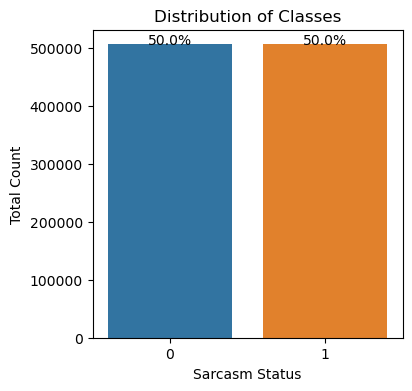

In [38]:
# Plotting the distribution of classes
plt.figure(figsize=(4,4))
ax = sns.countplot(x='label',  data= df)
ax.set(title = "Distribution of Classes", xlabel="Sarcasm Status", ylabel = "Total Count")
total = float(len(df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 3, '{:1.1f}%'.format((height/total)*100), ha="center") 
plt.show()

The graph above ensures that the dataset is balanced as the proportion of the sarcastic and non-sarcastic comments are same (50%).

### 2. Comment lengths

In [39]:
df['comment_length'] = df['comment'].str.len()
df['comment_length'].describe()

count    1.010771e+06
mean     5.669240e+01
std      6.182130e+01
min      1.000000e+00
25%      2.700000e+01
50%      4.600000e+01
75%      7.400000e+01
max      1.000000e+04
Name: comment_length, dtype: float64

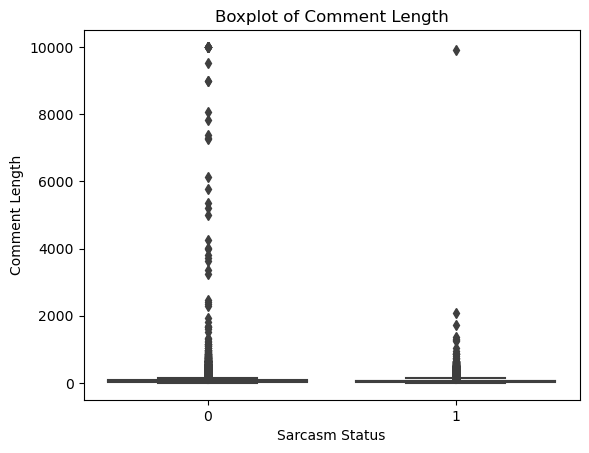

In [40]:
# boxplot of comment length
sns.boxplot(x='label', y='comment_length', data=df)
plt.xlabel('Sarcasm Status')
plt.ylabel('Comment Length')
plt.title('Boxplot of Comment Length')
plt.show()

From the quantile and boxplot of comment lengths, the majority of comment lengths are clustered within 100, with some individual very large outliers. And compared to non-sarcastic comments, sarcastic comments have fewer outliers with very long text.

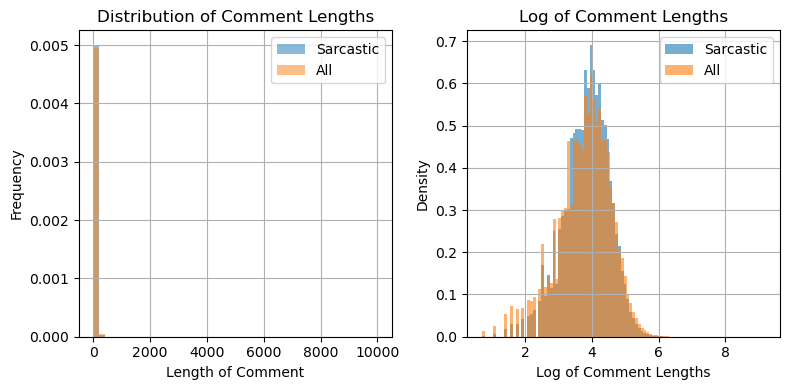

In [41]:
# Distribution of comment lengths
df['comment_length'] = df['comment'].str.len()

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
df[df['label']==1]['comment_length'].plot(kind='hist', bins=50, alpha=0.5, label='Sarcastic', legend=True, density=True)
df['comment_length'].plot(kind='hist', bins=50, alpha=0.5, label='All', legend=True, density=True)
plt.title('Distribution of Comment Lengths')
plt.xlabel('Length of Comment')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
df['log_comment'] = df['comment'].apply(lambda text: np.log1p(len(text)))
df[df['label']==1]['log_comment'].hist(alpha=0.6,label='Sarcastic', density=True ,bins=100)
#df[df['label']==0]['log_comment'].hist(alpha=0.6,label='Non-Sarcastic', density=True, bins=100)
df['log_comment'].hist(alpha=0.6,label='All', density=True, bins=100)
plt.legend()
plt.xlabel('Log of Comment Lengths')
plt.ylabel('Density')
plt.title('Log of Comment Lengths')

plt.tight_layout()
plt.show()

According to the frequency distribution of comment lengths, it is evident that both sarcastic and all comments are mostly concentrated within a short length range. The majority of comments are less than 100 characters long, with very few comments exceeding this length. 

Due to the long-tail distribution, We plot a logarithmic distribution of comment lengths to get a better view of its distribution characteristics. It can be observed that the log-length distributions of both sarcastic and all comments have a similar shape, roughly following a normal distribution. Sarcastic comments tend to be slightly shorter than all comments, as indicated by the higher density of the sarcastic comments curve on the left side of the chart.

### 3. Wordcloud of comments

Text(0.5, 1.0, 'Word Cloud for Sarcastic Comments')

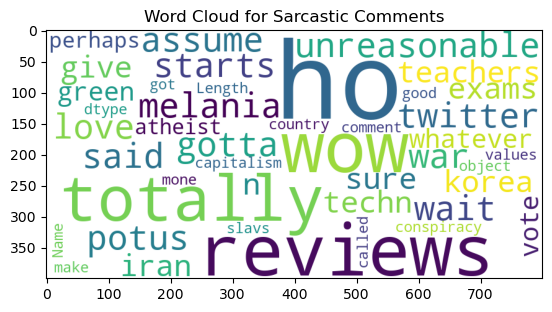

In [42]:
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white', #max_words = 200, 
                      #max_font_size = 100, random_state = 17, 
                      width=800, height=400)

# Word cloud for sarcastic comments
wordcloud.generate(str(df.loc[df['label'] == 1, 'comment']))
plt.imshow(wordcloud)
plt.title('Word Cloud for Sarcastic Comments')

Text(0.5, 1.0, 'Word Cloud for Non-Sarcastic Comments')

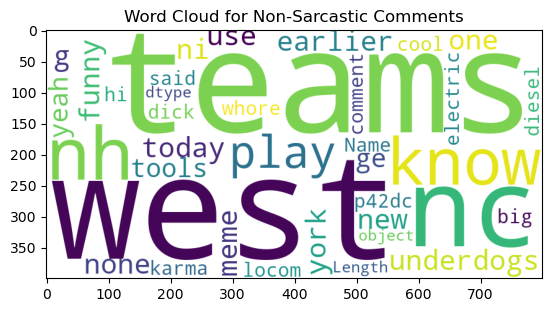

In [32]:
# Word cloud for non-sarcastic comments
wordcloud.generate(str(df.loc[df['label'] == 0, 'comment']))
plt.imshow(wordcloud)
plt.title('Word Cloud for Non-Sarcastic Comments')

Text(0.5, 1.0, 'Word Cloud for All Comments')

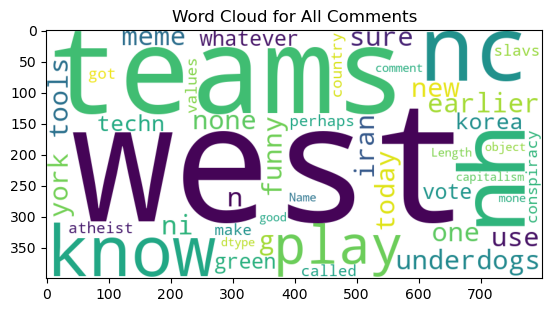

In [43]:
# Word cloud for all comments
wordcloud.generate(str(df['comment']))
plt.imshow(wordcloud)
plt.title('Word Cloud for All Comments')

Comparative Analysis of wordclouds:

Sarcastic comments tend to have a critical, mocking, or exaggerated tone, with frequent words 'wow' and 'totally'. And there are words reflecting skepticism and humor like 'unreasonable' and 'assume'. Non-sarcastic comments appear to be more straightforward and informative, focusing on specific subjects like sports, current events, and general knowledge.  
Sarcastic comments frequently use words that imply judgment or exaggeration, while non-sarcastic comments use more neutral and descriptive language, focusing on factual or supportive content.

### 4. Top popular subreddits & Sarcastic comments

In [10]:
# Getting the top 10 popular subreddits
df['subreddit'].value_counts()[:10]

subreddit
AskReddit          65674
politics           39493
worldnews          26375
leagueoflegends    21034
pcmasterrace       18987
funny              17939
news               16891
pics               16152
todayilearned      14159
nfl                14149
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Comments in Top 10 Subreddits')

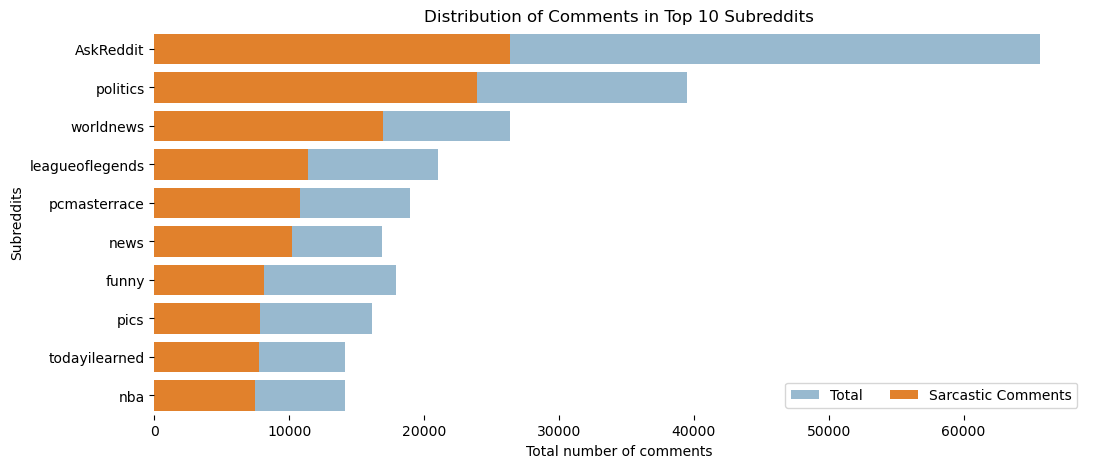

In [46]:
top_reddits =['AskReddit', 'politics', 'worldnews', 'leagueoflegends', 'pcmasterrace', 'news', 'funny', 'pics', 'todayilearned', 'nba']
subreddit = pd.DataFrame()
subreddit['subreddit'] = top_reddits
subreddit['sarcastic'] = np.nan
subreddit['natural'] = np.nan
subreddit['total'] = np.nan

# Calculating the count of Sarcastic and Natural comments for the top 10 subreddits 
for i in range(len(top_reddits)):
    temp = df.loc[df['subreddit'] == subreddit.subreddit.iloc[i]]
    length = len(temp)
    count_sarcastic = len(temp.loc[temp['label'] == 1])
    subreddit.sarcastic.iloc[i] = count_sarcastic
    subreddit.natural.iloc[i] = length - count_sarcastic
    subreddit.total.iloc[i] = length

# Plotting the distribution of comments in the top 10 subreddits
f, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="total", y="subreddit", data=subreddit,
            label="Total", color="#1f77b4", alpha=0.5)
sns.barplot(x="sarcastic", y="subreddit", data=subreddit,
            label="Sarcastic Comments", color="#ff7f0e", alpha=1)
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="Subreddits",
       xlabel="Total number of comments")
sns.despine(left=True, bottom=True)
plt.title('Distribution of Comments in Top 10 Subreddits')

### 5. Sentiment analysis for the comments

In [6]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# calculate sentiment scores
df['comment'] = df['comment'].astype(str)
df['sentiment'] = df['comment'].apply(lambda x: sia.polarity_scores(x)['compound'])

sarcastic_sentiment = df[df['label'] == 1]['sentiment']
non_sarcastic_sentiment = df[df['label'] == 0]['sentiment']

print('sarcastic_sentiment:')
print(sarcastic_sentiment.describe())
print('non_sarcastic_sentiment:')
print(non_sarcastic_sentiment.describe())

sarcastic_sentiment:
count    505413.000000
mean          0.061515
std           0.402286
min          -0.997600
25%          -0.102700
50%           0.000000
75%           0.369700
max           0.999100
Name: sentiment, dtype: float64
non_sarcastic_sentiment:
count    505413.000000
mean          0.058108
std           0.370506
min          -1.000000
25%           0.000000
50%           0.000000
75%           0.340000
max           0.999900
Name: sentiment, dtype: float64


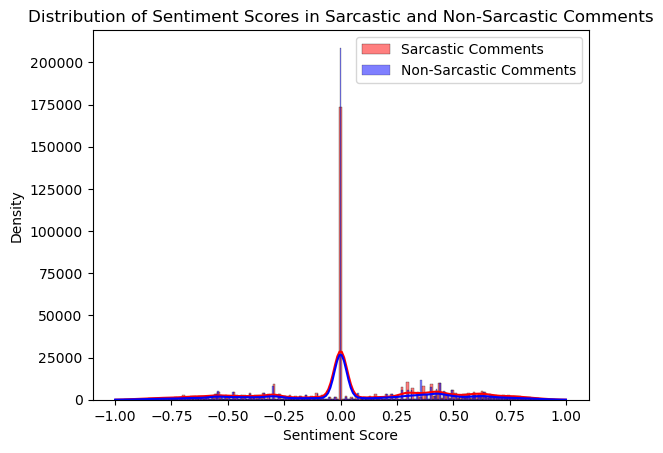

In [24]:
# Distribution of sentiment scores in sarcastic and non-sarcastic comments
sns.histplot(sarcastic_sentiment, color='red', label='Sarcastic Comments', kde=True)
sns.histplot(non_sarcastic_sentiment, color='blue', label='Non-Sarcastic Comments', kde=True)
plt.legend()
plt.title('Distribution of Sentiment Scores in Sarcastic and Non-Sarcastic Comments')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

Sentiment scores, ranging from -1 to 1, where -1 indicates very negative sentiment and 1 indicates very positive sentiment.
 
There is a significant peak at a sentiment score of 0 for both sarcastic and non-sarcastic comments, indicating that most comments are neutral in sentiment. The overall distribution patterns of sentiment scores in sarcastic and non-sarcastic comments are quite similar, indicating that both types of comments generally cover a similar range of sentiment scores. However, there are some differences in trends, sarcastic comments are more likely to have slightly negative sentiments compared to non-sarcastic comments, which tend to have more positive sentiments.

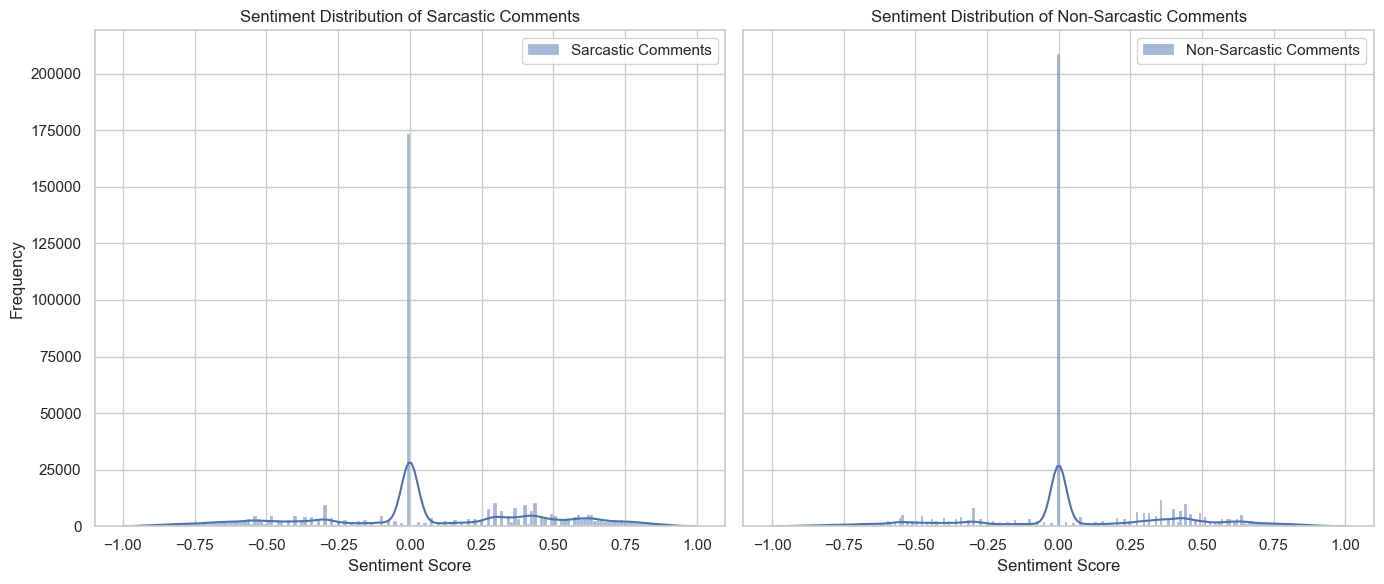

In [53]:
# Sentiment distribution of sarcastic and non-sarcastic comments
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# histplot of sarcastic comments sentiment
sns.histplot(sarcastic_sentiment, label='Sarcastic Comments', kde=True, ax=axes[0])
axes[0].set_title('Sentiment Distribution of Sarcastic Comments')
axes[0].set_xlabel('Sentiment Score')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# histplot of non-sarcastic comments sentiment
sns.histplot(non_sarcastic_sentiment, label='Non-Sarcastic Comments', kde=True, ax=axes[1])
axes[1].set_title('Sentiment Distribution of Non-Sarcastic Comments')
axes[1].set_xlabel('Sentiment Score')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

### 6. Sentimental difference between comments and parent comments

In [18]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

# calculate sentiment score for comment and parent comment
df['comment_sentiment'] = df['comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['parent_sentiment'] = df['parent_comment'].apply(lambda x: sia.polarity_scores(x)['compound'])

# sentiment difference between comment and parent comment
df['sentiment_difference'] = df['comment_sentiment'] - df['parent_sentiment']

sarcastic_diff = df[df['label'] == 1]['sentiment_difference']
non_sarcastic_diff = df[df['label'] == 0]['sentiment_difference']

print("sentiment difference for sarcasm comments:")
print(sarcastic_diff.describe())
print("\nsentiment difference for non-sarcasm comments:")
print(non_sarcastic_diff.describe())

sentiment difference for sarcasm comments:
count    505413.000000
mean          0.049805
std           0.601286
min          -1.941900
25%          -0.361200
50%           0.000000
75%           0.458800
max           1.973700
Name: sentiment_difference, dtype: float64

sentiment difference for non-sarcasm comments:
count    505413.000000
mean         -0.001518
std           0.555630
min          -1.980200
25%          -0.381100
50%           0.000000
75%           0.369400
max           1.936500
Name: sentiment_difference, dtype: float64


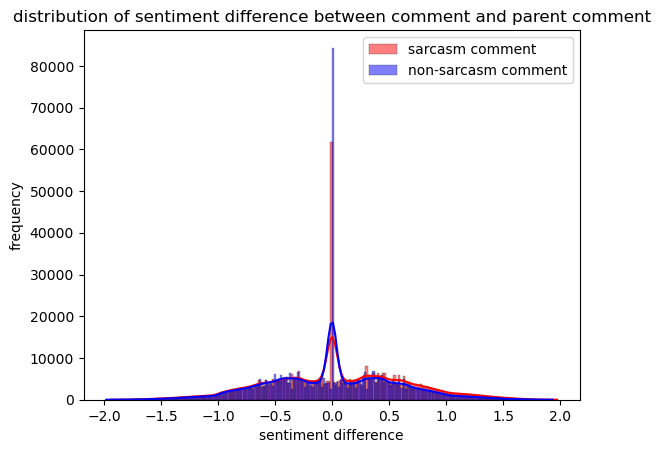

In [19]:
sns.histplot(sarcastic_diff, color='red', label='sarcasm comment', kde=True)
sns.histplot(non_sarcastic_diff, color='blue', label='non-sarcasm comment', kde=True)
plt.legend()
plt.title('distribution of sentiment difference between comment and parent comment')
plt.xlabel('sentiment difference')
plt.ylabel('frequency')
plt.show()

Sentiment difference = comment sentiment - parent comment sentiment (ranging from -2 to 2).

There is a significant peak at a sentiment difference of 0, especially for non-sarcastic comments, indicating that most comments have little to no sentiment difference from their parent comments.

At the 0 sentiment difference point, non-sarcastic comments have a noticeably higher peak than sarcastic comments, suggesting that non-sarcastic comments tend to have more similar sentiments to their parent comments.  
At the sides of the sentiment difference range, sarcastic comments have a slightly higher distribution, indicating that sarcastic comments are more likely to have a different sentiment from their parent comments.

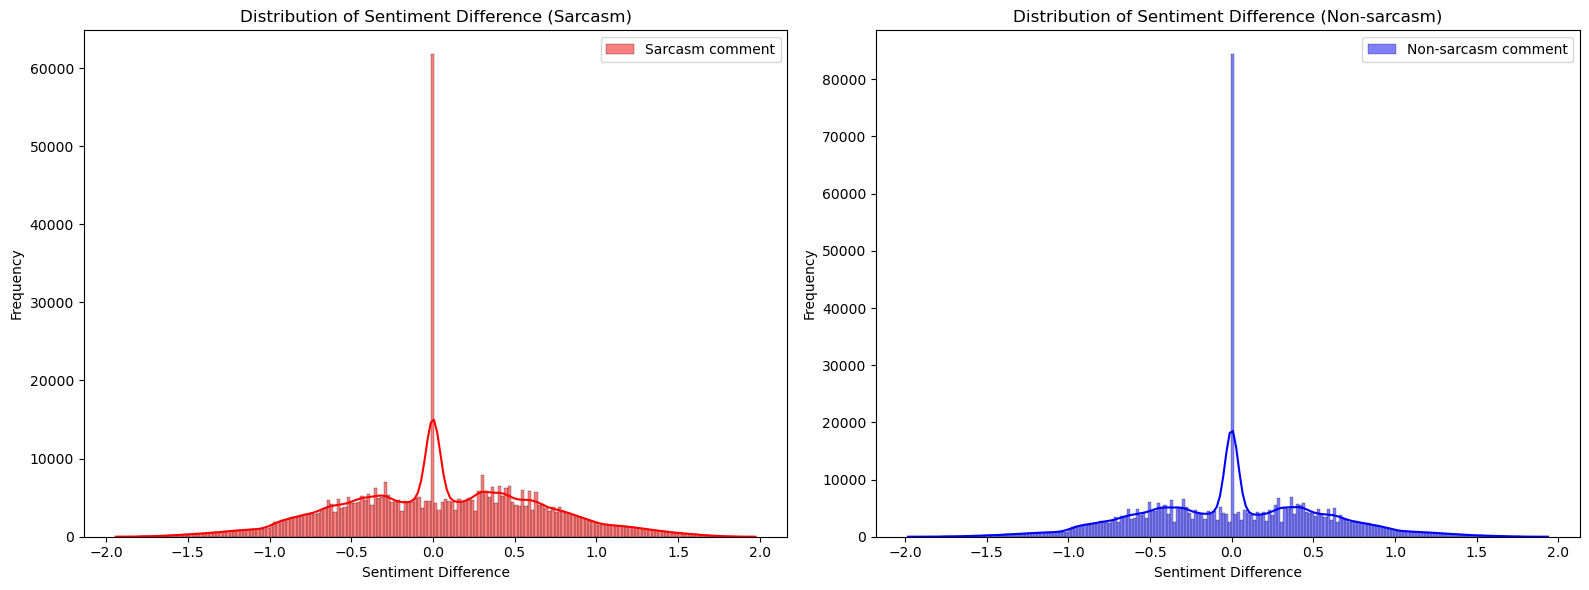

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(sarcastic_diff, color='red', label='Sarcasm comment', kde=True, ax=axes[0])
axes[0].set_title('Distribution of Sentiment Difference (Sarcasm)')
axes[0].set_xlabel('Sentiment Difference')
axes[0].set_ylabel('Frequency')
axes[0].legend()


sns.histplot(non_sarcastic_diff, color='blue', label='Non-sarcasm comment', kde=True, ax=axes[1])
axes[1].set_title('Distribution of Sentiment Difference (Non-sarcasm)')
axes[1].set_xlabel('Sentiment Difference')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

### 7. Detection of specific patterns (between comments and parent comments)

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# preprocess text
def preprocess(text):
    text = text.lower() 
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

df['parent_tokens'] = df['parent_comment'].apply(preprocess)
df['comment_tokens'] = df['comment'].apply(preprocess)

In [ ]:
# Specific pattern detection and statistical analysis
from collections import defaultdict

# define patterns to detect
patterns = ['i think', 'really', 'of course']

# intialize pattern counts
pattern_counts = defaultdict(lambda: {'total': 0, 'sarcastic': 0})

# statistics of pattern counts
for _, row in df.iterrows():
    parent_text = ' '.join(row['parent_tokens'])
    is_sarcastic = row['label'] == 'sarcastic'
    
    for pattern in patterns:
        if pattern in parent_text:
            pattern_counts[pattern]['total'] += 1
            if is_sarcastic:
                pattern_counts[pattern]['sarcastic'] += 1

# calculate the ratio of sarcastic comments for each pattern
for pattern, counts in pattern_counts.items():
    counts['sarcastic_ratio'] = counts['sarcastic'] / counts['total'] if counts['total'] > 0 else 0

print(pattern_counts)

In [ ]:
# extract pattern counts and sarcastic ratios
patterns = list(pattern_counts.keys())
total_counts = [pattern_counts[pattern]['total'] for pattern in patterns]
sarcastic_ratios = [pattern_counts[pattern]['sarcastic_ratio'] for pattern in patterns]

# plot the pattern counts and sarcastic ratios
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('patterns')
ax1.set_ylabel('counts', color=color)
ax1.bar(patterns, total_counts, color=color, alpha=0.6, label='counts')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('sarcastic ratio', color=color)
ax2.plot(patterns, sarcastic_ratios, color=color, marker='o', linestyle='-', label='sarcastic ratio')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Pattern Counts and Sarcastic Ratios')
plt.show()